## Long short-term memory(LSTM) Implementation - Univariate

### 1. Data Understanding and Exploration

Let's first import the required libraries and have a look at the dataset and understand the size, attribute names etc.

In [1]:
import numpy as np
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re

C:\Users\u61152\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Build a function to get the data from the IMF website and save it locally

URL = 'https://www.imf.org/~/media/Files/Publications/WEO/WEO-Database/2020/02/WEOOct2020all.xls'
def get_data_from_IMF(URL):
    urllib.request.urlretrieve(URL, '.')

In [4]:
#get_data_from_IMF(URL)

In [5]:
# Reading the dataset
imf = pd.read_excel("data/WEOOct2020all.xlsx", na_values=['--'])


In [6]:
imf.shape

(8777, 56)

In [7]:
# Let's take a look at the first few rows
imf.head()

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,1255.288,1270.216,1319.902,1253.906,1304.063,1363.060,1424.397,1481.497,1540.937,2019.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,2.647,1.189,3.912,-5.000,4.000,4.524,4.500,4.009,4.012,2019.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,1285.460,1327.690,1469.596,1465.922,1597.738,1741.832,1893.023,2047.665,2215.013,2019.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,18.910,18.401,18.876,19.006,19.692,20.829,22.022,23.169,24.372,2019.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,74.712,77.416,81.880,78.884,83.852,89.205,94.908,100.600,106.685,2019.0


#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attributes; some non-obvious ones are:

In [8]:
imf["Country"].unique().size

196

In [9]:
imf['Country'].astype('category').value_counts()

Zimbabwe           45
Egypt              45
Hong Kong SAR      45
Honduras           45
Haiti              45
                   ..
Pakistan           45
Oman               45
Norway             45
North Macedonia    45
Afghanistan        45
Name: Country, Length: 195, dtype: int64

In [10]:
imf['WEO Subject Code'].astype('category').value_counts()

TX_RPCH         195
NGDP            195
LUR             195
LP              195
LE              195
GGX_NGDP        195
GGXWDN_NGDP     195
GGXWDN          195
GGXWDG_NGDP     195
GGXWDG          195
GGXONLB_NGDP    195
GGXONLB         195
GGXCNL_NGDP     195
GGXCNL          195
GGX             195
GGSB_NPGDP      195
GGSB            195
GGR_NGDP        195
GGR             195
FLIBOR6         195
BCA_NGDPD       195
NGAP_NPGDP      195
NGDPD           195
TXG_RPCH        195
NGDPDPC         195
TM_RPCH         195
TMG_RPCH        195
PPPSH           195
PPPPC           195
PPPGDP          195
PPPEX           195
PCPIPCH         195
PCPIEPCH        195
PCPIE           195
PCPI            195
NID_NGDP        195
NGSD_NGDP       195
NGDP_RPCH       195
NGDP_R          195
NGDP_FY         195
NGDP_D          195
NGDPRPPPPC      195
NGDPRPC         195
NGDPPC          195
BCA             195
Name: WEO Subject Code, dtype: int64

In [11]:
imf["WEO Subject Code"].unique()

array(['NGDP_R', 'NGDP_RPCH', 'NGDP', 'NGDPD', 'PPPGDP', 'NGDP_D',
       'NGDPRPC', 'NGDPRPPPPC', 'NGDPPC', 'NGDPDPC', 'PPPPC',
       'NGAP_NPGDP', 'PPPSH', 'PPPEX', 'NID_NGDP', 'NGSD_NGDP', 'PCPI',
       'PCPIPCH', 'PCPIE', 'PCPIEPCH', 'FLIBOR6', 'TM_RPCH', 'TMG_RPCH',
       'TX_RPCH', 'TXG_RPCH', 'LUR', 'LE', 'LP', 'GGR', 'GGR_NGDP', 'GGX',
       'GGX_NGDP', 'GGXCNL', 'GGXCNL_NGDP', 'GGSB', 'GGSB_NPGDP',
       'GGXONLB', 'GGXONLB_NGDP', 'GGXWDN', 'GGXWDN_NGDP', 'GGXWDG',
       'GGXWDG_NGDP', 'NGDP_FY', 'BCA', 'BCA_NGDPD', nan], dtype=object)

In [12]:
imf['Subject Descriptor'].astype('category').value_counts()

Gross domestic product, current prices                                                585
Gross domestic product per capita, current prices                                     585
Gross domestic product, constant prices                                               390
General government gross debt                                                         390
General government net debt                                                           390
General government net lending/borrowing                                              390
General government primary net lending/borrowing                                      390
General government revenue                                                            390
General government structural balance                                                 390
General government total expenditure                                                  390
Gross domestic product per capita, constant prices                                    390
Current ac

In [13]:
#print(imf.info())

In [14]:
# Few years data are the OBJECT type, lets convert those into float
#df_obj = imf.select_dtypes(include=[object])
#cols = imf.select_dtypes([np.object]).columns
filteredColumns = imf.dtypes[imf.dtypes == np.object]
listOfColumnNames = list(filteredColumns.index)
print(listOfColumnNames)
#list(df_obj.columns)

['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country', 'Subject Descriptor', 'Subject Notes', 'Units', 'Scale', 'Country/Series-specific Notes']


In [15]:
# check for NAN value
imf.isnull().sum()

WEO Country Code                    1
ISO                                 2
WEO Subject Code                    2
Country                             2
Subject Descriptor                  2
Subject Notes                     197
Units                               2
Scale                            4877
Country/Series-specific Notes    1188
1980                             4969
1981                             4825
1982                             4783
1983                             4736
1984                             4705
1985                             4635
1986                             4592
1987                             4573
1988                             4480
1989                             4418
1990                             3922
1991                             3761
1992                             3386
1993                             3182
1994                             3053
1995                             2691
1996                             2547
1997        

In [16]:
# Dropping scale column as it has too many NAN, And not have any business impact
imf = imf.drop(['Scale'], axis=1)

In [17]:
# check for missing values
# chek for unquie values
# check for data types

unique_values = imf.nunique()
filtered_empty = imf.isnull().sum(axis=0)
mis_val_percent = imf.isna().mean().round(4) * 100
data_type = imf.dtypes
val_table = pd.concat([unique_values,filtered_empty, mis_val_percent, data_type], axis=1,sort =True)
val_table_columns = val_table.rename(columns = {0: 'Unique', 1 : 'Missing Values', 2 : 'missing %', 3: 'type'})
val_table_columns = val_table_columns.sort_values('missing %', ascending=False)
val_table_columns 

,Unique,Missing Values,missing %,type
1980,3398,4969,56.61,float64
1981,3537,4825,54.97,float64
1982,3606,4783,54.49,float64
1983,3618,4736,53.96,float64
1984,3651,4705,53.61,float64
1985,3737,4635,52.81,float64
1986,3773,4592,52.32,float64
1987,3811,4573,52.10,float64
1988,3891,4480,51.04,float64
1989,3955,4418,50.34,float64


In [18]:
# we can see so many nulls in old data & years for few countries, since database is not big lets impute with zero for now
# we might modify or delete this step based on our model performance

imf = imf.fillna(0)


In [19]:
# we can notice some tail comments appended in last of the data file, lets remove
imf.drop(imf.loc[imf['ISO']==0].index, inplace=True)
imf.tail(2)

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Country/Series-specific Notes,1980,1981,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,Estimates Start After
8773,698,ZWE,BCA,Zimbabwe,Current account balance,Current account is all transactions other than...,U.S. dollars,Source: Reserve Bank of Zimbabwe and Ministry ...,-0.301,-0.674,...,-0.284,-1.229,0.208,-0.505,-0.160,-0.288,-0.589,-0.603,-0.540,2018.0
8774,698,ZWE,BCA_NGDPD,Zimbabwe,Current account balance,Current account is all transactions other than...,Percent of GDP,"See notes for: Gross domestic product, curren...",0.000,0.000,...,-1.299,-5.896,1.112,-3.606,-2.005,-3.416,-6.735,-6.534,-5.537,2018.0


In [20]:
# Row wise Null
#imf.isnull().all(axis = 1).sum()

In [21]:
# Lets drop few columns on business justification as those are of no use in inference
# "Estimates Start After"
# "Subject Notes"
# "Country/Series-specific Notes"

In [22]:
imf.drop(['Estimates Start After','Subject Notes','Country/Series-specific Notes'] , axis=1, inplace=True)
imf.head(2)

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Units,1980,1981,1982,1983,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",National currency,0.0,0.0,0.0,0.0,...,1222.917,1255.288,1270.216,1319.902,1253.906,1304.063,1363.060,1424.397,1481.497,1540.937
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Percent change,0.0,0.0,0.0,0.0,...,2.164,2.647,1.189,3.912,-5.000,4.000,4.524,4.500,4.009,4.012


In [23]:
#imf = imf.select_dtypes(include ='float64') 
#imf.head()

In [24]:
# remove all the catagorical varible to plot
unique_values = imf.nunique()
filtered_empty = imf.isnull().sum(axis=0)
mis_val_percent = imf.isna().mean().round(4) * 100
data_type = imf.dtypes
val_table = pd.concat([unique_values,filtered_empty, mis_val_percent, data_type], axis=1,sort =True)
val_table_columns = val_table.rename(columns = {0: 'Unique', 1 : 'Missing Values', 2 : 'missing %', 3: 'type'})
val_table_columns = val_table_columns.sort_values('missing %', ascending=False)
val_table_columns 

,Unique,Missing Values,missing %,type
WEO Country Code,195,0,0.0,object
ISO,195,0,0.0,object
2002,6552,0,0.0,float64
2003,6587,0,0.0,float64
2004,6680,0,0.0,float64
2005,6668,0,0.0,float64
2006,6688,0,0.0,float64
2007,6729,0,0.0,float64
2008,6800,0,0.0,float64
2009,6852,0,0.0,float64


In [25]:
imf["Subject Descriptor"].unique()

array(['Gross domestic product, constant prices',
       'Gross domestic product, current prices',
       'Gross domestic product, deflator',
       'Gross domestic product per capita, constant prices',
       'Gross domestic product per capita, current prices',
       'Output gap in percent of potential GDP',
       'Gross domestic product based on purchasing-power-parity (PPP) share of world total',
       'Implied PPP conversion rate', 'Total investment',
       'Gross national savings', 'Inflation, average consumer prices',
       'Inflation, end of period consumer prices',
       'Six-month London interbank offered rate (LIBOR)',
       'Volume of imports of goods and services',
       'Volume of Imports of goods',
       'Volume of exports of goods and services',
       'Volume of exports of goods', 'Unemployment rate', 'Employment',
       'Population', 'General government revenue',
       'General government total expenditure',
       'General government net lending/borrowing',

In [26]:
imf["WEO Subject Code"].unique()

array(['NGDP_R', 'NGDP_RPCH', 'NGDP', 'NGDPD', 'PPPGDP', 'NGDP_D',
       'NGDPRPC', 'NGDPRPPPPC', 'NGDPPC', 'NGDPDPC', 'PPPPC',
       'NGAP_NPGDP', 'PPPSH', 'PPPEX', 'NID_NGDP', 'NGSD_NGDP', 'PCPI',
       'PCPIPCH', 'PCPIE', 'PCPIEPCH', 'FLIBOR6', 'TM_RPCH', 'TMG_RPCH',
       'TX_RPCH', 'TXG_RPCH', 'LUR', 'LE', 'LP', 'GGR', 'GGR_NGDP', 'GGX',
       'GGX_NGDP', 'GGXCNL', 'GGXCNL_NGDP', 'GGSB', 'GGSB_NPGDP',
       'GGXONLB', 'GGXONLB_NGDP', 'GGXWDN', 'GGXWDN_NGDP', 'GGXWDG',
       'GGXWDG_NGDP', 'NGDP_FY', 'BCA', 'BCA_NGDPD'], dtype=object)

In [27]:
#so there is no use of subject code, we will use descriptor, lets remove code
imf.drop(['WEO Subject Code'] , axis=1, inplace=True)
#there is no use of year 2021,since we have to predict it, lets remove
imf.drop([2021] , axis=1, inplace=True)

In [28]:
imf.head(2)

,WEO Country Code,ISO,Country,Subject Descriptor,Units,1980,1981,1982,1983,1984,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
0,512,AFG,Afghanistan,"Gross domestic product, constant prices",National currency,0.0,0.0,0.0,0.0,0.0,...,1197.012,1222.917,1255.288,1270.216,1319.902,1253.906,1363.060,1424.397,1481.497,1540.937
1,512,AFG,Afghanistan,"Gross domestic product, constant prices",Percent change,0.0,0.0,0.0,0.0,0.0,...,0.988,2.164,2.647,1.189,3.912,-5.000,4.524,4.500,4.009,4.012


In [29]:
# Now we will try to take each indicator one by one, lets rename subject descriptor to economy indicators
imf["Subject Descriptor"].unique()
imf.rename(columns = {'Subject Descriptor':'Economic Indicator'}, inplace = True) 

In [30]:
imf.head(2)

,WEO Country Code,ISO,Country,Economic Indicator,Units,1980,1981,1982,1983,1984,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
0,512,AFG,Afghanistan,"Gross domestic product, constant prices",National currency,0.0,0.0,0.0,0.0,0.0,...,1197.012,1222.917,1255.288,1270.216,1319.902,1253.906,1363.060,1424.397,1481.497,1540.937
1,512,AFG,Afghanistan,"Gross domestic product, constant prices",Percent change,0.0,0.0,0.0,0.0,0.0,...,0.988,2.164,2.647,1.189,3.912,-5.000,4.524,4.500,4.009,4.012


####  Split data across each economic indicator


In [31]:
# Gross domestic product, constant prices
imf_gdp_constant_price = imf[imf['Economic Indicator']=='Gross domestic product, constant prices']
#Gross domestic product, current prices
imf_gdp_current_price = imf[imf['Economic Indicator']=='Gross domestic product, current prices']
# Gross domestic product per capita, constant prices
imf_gdp_per_capita_con_price = imf[imf['Economic Indicator']=='Gross domestic product per capita, constant prices']
# Inflation, average consumer prices
imf_inflation_avg_con_prices = imf[imf['Economic Indicator']=='Inflation, average consumer prices']
# Inflation, end of period consumer prices
imf_inflation_eop_con_prices = imf[imf['Economic Indicator']=='Inflation, end of period consumer prices']
# Unemployment rate
imf_unemployment = imf[imf['Economic Indicator']=='Unemployment rate']
# General government net lending/borrowing
imf_gov_len_bor = imf[imf['Economic Indicator']=='General government net lending/borrowing']
# Current account balance
imf_current_acc_bal = imf[imf['Economic Indicator']=='Current account balance']

In [32]:
imf_gdp_constant_price.head(2)

,WEO Country Code,ISO,Country,Economic Indicator,Units,1980,1981,1982,1983,1984,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
0,512,AFG,Afghanistan,"Gross domestic product, constant prices",National currency,0.0,0.0,0.0,0.0,0.0,...,1197.012,1222.917,1255.288,1270.216,1319.902,1253.906,1363.060,1424.397,1481.497,1540.937
1,512,AFG,Afghanistan,"Gross domestic product, constant prices",Percent change,0.0,0.0,0.0,0.0,0.0,...,0.988,2.164,2.647,1.189,3.912,-5.000,4.524,4.500,4.009,4.012


##### Remove categorical variable
###### Since we have country name, we don't need any other variable for row-wise uniqueness

In [33]:
imf_gdp_constant_price.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_gdp_current_price.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_gdp_per_capita_con_price.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_inflation_avg_con_prices.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_inflation_eop_con_prices.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_unemployment.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_gov_len_bor.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_current_acc_bal.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)

In [34]:
imf_gdp_constant_price

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
0,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1197.012,1222.917,1255.288,1270.216,1319.902,1253.906,1363.060,1424.397,1481.497,1540.937
1,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.988,2.164,2.647,1.189,3.912,-5.000,4.524,4.500,4.009,4.012
45,Albania,311.514,329.270,338.819,342.546,349.397,344.156,363.428,360.521,355.474,...,735.657,760.042,788.940,821.061,839.449,776.248,871.468,909.038,940.470,972.719
46,Albania,2.684,5.700,2.900,1.100,2.000,-1.500,5.600,-0.800,-1.400,...,2.219,3.315,3.802,4.071,2.240,-7.529,5.818,4.311,3.458,3.429
90,Algeria,2596.368,2674.259,2845.412,2999.064,3167.012,3344.364,3337.676,3314.312,3251.340,...,7044.731,7270.163,7364.675,7467.780,7527.523,7116.439,7529.254,7615.746,7694.133,7767.167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8641,Yemen,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-27.995,-9.375,-5.072,0.752,2.100,-5.000,2.500,6.695,6.374,6.217
8685,Zambia,39.933,42.581,41.341,40.868,40.166,40.663,41.353,41.970,45.861,...,125.004,129.700,134.271,139.688,141.702,134.856,137.068,138.733,140.440,142.140
8686,Zambia,3.854,6.631,-2.912,-1.145,-1.718,1.237,1.698,1.491,9.271,...,2.920,3.757,3.524,4.035,1.442,-4.831,1.051,1.214,1.231,1.210
8730,Zimbabwe,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,18.190,18.325,19.187,19.858,18.559,16.633,17.755,18.138,18.530,18.930


In [35]:
imf_gdp_constant_price.index

Int64Index([   0,    1,   45,   46,   90,   91,  135,  136,  180,  181,
            ...
            8550, 8551, 8595, 8596, 8640, 8641, 8685, 8686, 8730, 8731],
           dtype='int64', length=390)

##### Split data into train & test

In [36]:
#imf_gdp_constant_price.columns

In [37]:
def display_table(df1, df2, name1 , name2):
    styles = [
    dict(selector="th", props=[("font-size", "100%"),("text-align", "center")]),
    dict(selector="caption", props=[("font-size", "110%"),("text-align", "center"),("font-weight", "bold")])
    ]
    
    df1_sty = df1.style.set_table_styles(styles).set_caption(name1).set_table_attributes("style='display:inline'")
    df2_sty = df2.style.set_table_styles(styles).set_caption(name2).set_table_attributes("style='display:inline'")
 
    return display_html(df1_sty._repr_html_()+"\xa0\xa0\xa0\xa0\xa0\xa0"+df2_sty._repr_html_(), raw=True)

In [38]:
#imf_gdp_constant_price_4_years_train.shape

In [39]:
def get_input_data(input):
    nb_timesteps = 4
    flag = 0
    for sample in range(input.shape[0]):
        tmp = np.array([input[sample,i:i+nb_timesteps,:] for i in range(input.shape[1] - nb_timesteps + 1)])
        if flag==0:
            new_input = tmp
            flag = 1
        else:
            new_input = np.concatenate((new_input,tmp))
    return new_input

In [40]:
imf_gdp_constant_price.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
0,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1197.012,1222.917,1255.288,1270.216,1319.902,1253.906,1363.060,1424.397,1481.497,1540.937
1,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.988,2.164,2.647,1.189,3.912,-5.000,4.524,4.500,4.009,4.012
45,Albania,311.514,329.270,338.819,342.546,349.397,344.156,363.428,360.521,355.474,...,735.657,760.042,788.940,821.061,839.449,776.248,871.468,909.038,940.470,972.719
46,Albania,2.684,5.700,2.900,1.100,2.000,-1.500,5.600,-0.800,-1.400,...,2.219,3.315,3.802,4.071,2.240,-7.529,5.818,4.311,3.458,3.429
90,Algeria,2596.368,2674.259,2845.412,2999.064,3167.012,3344.364,3337.676,3314.312,3251.340,...,7044.731,7270.163,7364.675,7467.780,7527.523,7116.439,7529.254,7615.746,7694.133,7767.167


In [41]:
imf_gdp_current_price.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
2,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1226.570,1222.917,1285.460,1327.690,1469.596,1465.922,1741.832,1893.023,2047.665,2215.013
3,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,20.220,17.994,18.910,18.401,18.876,19.006,20.829,22.022,23.169,24.372
4,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,72.056,70.098,74.712,77.416,81.880,78.884,89.205,94.908,100.600,106.685
47,Albania,18.489,19.126,19.698,19.900,19.645,20.065,20.692,20.531,20.238,...,1434.307,1472.479,1550.645,1635.715,1678.431,1570.144,1827.015,1951.797,2077.315,2210.570
48,Albania,1.946,2.229,2.296,2.319,2.290,2.339,2.587,2.566,2.530,...,11.389,11.862,13.053,15.147,15.276,14.034,16.130,17.728,18.856,20.052


##### lets choose one country at a time to prepare the data for LSTM input

In [42]:
imf_gdp_current_price_ind = imf_gdp_current_price[imf_gdp_current_price['Country']=='India']

In [43]:
imf_gdp_constant_price_ind = imf_gdp_constant_price[imf_gdp_constant_price['Country']=='India']

In [44]:
imf_gdp_per_capita_con_price_ind = imf_gdp_per_capita_con_price[imf_gdp_per_capita_con_price['Country']=='India']

In [45]:
imf_inflation_avg_con_prices_ind = imf_inflation_avg_con_prices[imf_inflation_avg_con_prices['Country']=='India']

In [46]:
imf_inflation_eop_con_prices_ind = imf_inflation_eop_con_prices[imf_inflation_eop_con_prices['Country']=='India']

In [47]:
imf_unemployment_ind = imf_unemployment[imf_unemployment['Country']=='India']

In [48]:
imf_gov_len_bor_ind = imf_gov_len_bor[imf_gov_len_bor['Country']=='India']

In [49]:
def get_country(country_name, indicator):
    country_indicator = country_name+"_"+indicator
    return country_indicator

In [50]:
print(get_country('US','gdp'))

US_gdp


In [51]:
imf_gdp_current_price_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
3422,India,1496.419,1758.055,1966.437,2290.214,2566.109,2895.239,3239.491,3682.107,4368.927,...,137718.700,153916.700,170983.000,189712.400,203398.500,190539.549,238993.811,266985.342,297597.654,331039.499
3423,India,189.438,196.535,203.537,222.049,215.556,237.618,252.751,283.750,299.645,...,2103.588,2294.118,2652.755,2713.165,2868.930,2592.583,3094.177,3368.899,3657.454,3958.812
3424,India,372.282,431.979,474.612,529.148,569.189,618.044,660.602,703.784,798.752,...,7159.796,7735.002,8280.934,8998.685,9542.255,8681.303,10610.732,11627.486,12728.077,13909.252


In [52]:
imf_gdp_constant_price_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
3420,India,13436.118,14243.118,14738.171,15812.421,16416.572,17279.148,18104.497,18822.405,20634.585,...,113694.900,123081.900,131751.600,139814.30,145659.500,130672.588,153531.162,165248.200,177495.491,190243.855
3421,India,5.281,6.006,3.476,7.289,3.821,5.254,4.777,3.965,9.628,...,7.996,8.256,7.044,6.12,4.181,-10.289,7.986,7.632,7.411,7.182


In [53]:
imf_gdp_per_capita_con_price_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
3426,India,19223.211,19909.725,20127.528,21099.292,21408.264,22029.613,22574.883,22963.055,24639.225,...,86779.904,92926.394,98420.596,103365.747,106507.229,94581.464,108921.407,116082.19,123472.502,131155.872
3427,India,1208.229,1251.378,1265.068,1326.146,1345.566,1384.619,1418.891,1443.288,1548.640,...,5454.345,5840.668,6185.993,6496.808,6694.259,5944.693,6845.996,7296.07,7760.571,8243.490


In [54]:
imf_inflation_avg_con_prices_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
3436,India,8.960,10.094,10.875,12.241,13.038,13.853,15.085,16.451,17.638,...,132.323,138.278,143.259,148.171,155.227,162.907,175.481,182.279,189.467,197.126
3437,India,11.346,12.654,7.736,12.558,6.517,6.251,8.889,9.059,7.214,...,4.900,4.500,3.602,3.428,4.762,4.948,3.826,3.873,3.944,4.042


In [55]:
imf_inflation_eop_con_prices_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
3438,India,9.273,10.112,11.165,12.326,12.960,14.116,15.170,16.648,17.487,...,126.100,130.600,136.600,139.967,149.300,154.375,166.476,172.923,179.742,187.015
3439,India,12.819,9.048,10.420,10.398,5.144,8.920,7.464,9.743,5.040,...,5.259,3.569,4.594,2.465,6.668,3.399,3.720,3.872,3.943,4.047


In [56]:
imf_unemployment_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
3445,India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
imf_gov_len_bor_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
3452,India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-301.001,...,-9919.748,-10955.884,-10875.831,-11894.33,-16714.971,-24916.782,-23922.127,-25548.679,-27668.252,-30142.419
3453,India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.890,...,-7.203,-7.118,-6.361,-6.27,-8.218,-13.077,-10.010,-9.569,-9.297,-9.105


In [58]:
imf_gdp_current_price_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
3422,India,1496.419,1758.055,1966.437,2290.214,2566.109,2895.239,3239.491,3682.107,4368.927,...,137718.700,153916.700,170983.000,189712.400,203398.500,190539.549,238993.811,266985.342,297597.654,331039.499
3423,India,189.438,196.535,203.537,222.049,215.556,237.618,252.751,283.750,299.645,...,2103.588,2294.118,2652.755,2713.165,2868.930,2592.583,3094.177,3368.899,3657.454,3958.812
3424,India,372.282,431.979,474.612,529.148,569.189,618.044,660.602,703.784,798.752,...,7159.796,7735.002,8280.934,8998.685,9542.255,8681.303,10610.732,11627.486,12728.077,13909.252


In [59]:
#get_input_data(imf_gdp_current_price_ind)

In [60]:
imf_gdp_current_price_ind.drop(['Country'] , axis=1, inplace=True)

In [61]:
imf_gdp_current_price_ind.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
3422,1496.419,1758.055,1966.437,2290.214,2566.109,2895.239,3239.491,3682.107,4368.927,5019.282,...,137718.700,153916.700,170983.000,189712.400,203398.500,190539.549,238993.811,266985.342,297597.654,331039.499
3423,189.438,196.535,203.537,222.049,215.556,237.618,252.751,283.750,299.645,301.234,...,2103.588,2294.118,2652.755,2713.165,2868.930,2592.583,3094.177,3368.899,3657.454,3958.812
3424,372.282,431.979,474.612,529.148,569.189,618.044,660.602,703.784,798.752,879.436,...,7159.796,7735.002,8280.934,8998.685,9542.255,8681.303,10610.732,11627.486,12728.077,13909.252


In [62]:
df = imf_gdp_current_price_ind.rename(columns=imf_gdp_current_price_ind.iloc[0])

In [63]:
df

,1496.419,1758.055,1966.437,2290.214,2566.109,2895.239,3239.491,3682.107,4368.927,5019.282,...,137718.700,153916.700,170983.000,189712.400,203398.500,190539.549,238993.811,266985.342,297597.654,331039.499
3422,1496.419,1758.055,1966.437,2290.214,2566.109,2895.239,3239.491,3682.107,4368.927,5019.282,...,137718.700,153916.700,170983.000,189712.400,203398.500,190539.549,238993.811,266985.342,297597.654,331039.499
3423,189.438,196.535,203.537,222.049,215.556,237.618,252.751,283.750,299.645,301.234,...,2103.588,2294.118,2652.755,2713.165,2868.930,2592.583,3094.177,3368.899,3657.454,3958.812
3424,372.282,431.979,474.612,529.148,569.189,618.044,660.602,703.784,798.752,879.436,...,7159.796,7735.002,8280.934,8998.685,9542.255,8681.303,10610.732,11627.486,12728.077,13909.252


In [64]:
imf_gdp_current_price_ind.reset_index(drop=True, inplace=True)
imf_gdp_current_price_ind

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2022,2023,2024,2025
0,1496.419,1758.055,1966.437,2290.214,2566.109,2895.239,3239.491,3682.107,4368.927,5019.282,...,137718.700,153916.700,170983.000,189712.400,203398.500,190539.549,238993.811,266985.342,297597.654,331039.499
1,189.438,196.535,203.537,222.049,215.556,237.618,252.751,283.750,299.645,301.234,...,2103.588,2294.118,2652.755,2713.165,2868.930,2592.583,3094.177,3368.899,3657.454,3958.812
2,372.282,431.979,474.612,529.148,569.189,618.044,660.602,703.784,798.752,879.436,...,7159.796,7735.002,8280.934,8998.685,9542.255,8681.303,10610.732,11627.486,12728.077,13909.252


In [65]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        # find the end of this pattern
        end_ix = i + n_features
        # check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [66]:
# define input sequence
# choose a number of time steps
n_steps = 4
# split into samples
x_data, y_data = prepare_data(imf_gdp_current_price_ind.values.flatten(), n_steps)

In [67]:
print(x_data)

[[1.49641900e+03 1.75805500e+03 1.96643700e+03 2.29021400e+03]
 [1.75805500e+03 1.96643700e+03 2.29021400e+03 2.56610900e+03]
 [1.96643700e+03 2.29021400e+03 2.56610900e+03 2.89523900e+03]
 [2.29021400e+03 2.56610900e+03 2.89523900e+03 3.23949100e+03]
 [2.56610900e+03 2.89523900e+03 3.23949100e+03 3.68210700e+03]
 [2.89523900e+03 3.23949100e+03 3.68210700e+03 4.36892700e+03]
 [3.23949100e+03 3.68210700e+03 4.36892700e+03 5.01928200e+03]
 [3.68210700e+03 4.36892700e+03 5.01928200e+03 5.86212400e+03]
 [4.36892700e+03 5.01928200e+03 5.86212400e+03 6.73874500e+03]
 [5.01928200e+03 5.86212400e+03 6.73874500e+03 7.74545000e+03]
 [5.86212400e+03 6.73874500e+03 7.74545000e+03 8.91354600e+03]
 [6.73874500e+03 7.74545000e+03 8.91354600e+03 1.04559050e+04]
 [7.74545000e+03 8.91354600e+03 1.04559050e+04 1.22672490e+04]
 [8.91354600e+03 1.04559050e+04 1.22672490e+04 1.41927680e+04]
 [1.04559050e+04 1.22672490e+04 1.41927680e+04 1.57239360e+04]
 [1.22672490e+04 1.41927680e+04 1.57239360e+04 1.803377

In [68]:
print(y_data)

[2.56610900e+03 2.89523900e+03 3.23949100e+03 3.68210700e+03
 4.36892700e+03 5.01928200e+03 5.86212400e+03 6.73874500e+03
 7.74545000e+03 8.91354600e+03 1.04559050e+04 1.22672490e+04
 1.41927680e+04 1.57239360e+04 1.80337770e+04 2.02312960e+04
 2.17741270e+04 2.35584520e+04 2.53632660e+04 2.84150260e+04
 3.24221040e+04 3.69336880e+04 4.29470590e+04 4.98708960e+04
 5.63006000e+04 6.47783000e+04 7.78412000e+04 8.73633000e+04
 9.94401000e+04 1.12335200e+05 1.24679600e+05 1.37718700e+05
 1.53916700e+05 1.70983000e+05 1.89712400e+05 2.03398500e+05
 1.90539549e+05 2.38993811e+05 2.66985342e+05 2.97597654e+05
 3.31039499e+05 1.89438000e+02 1.96535000e+02 2.03537000e+02
 2.22049000e+02 2.15556000e+02 2.37618000e+02 2.52751000e+02
 2.83750000e+02 2.99645000e+02 3.01234000e+02 3.26608000e+02
 2.74842000e+02 2.93262000e+02 2.84194000e+02 3.33014000e+02
 3.66600000e+02 3.99791000e+02 4.23189000e+02 4.28767000e+02
 4.66841000e+02 4.76636000e+02 4.93934000e+02 5.23768000e+02
 6.18369000e+02 7.215890

In [69]:
x_data.shape

(131, 4)

In [70]:
y_data.shape

(131,)

In [71]:
from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(x_data, test_size=0.2)
train_y, test_y = train_test_split(y_data, test_size=0.2)

In [72]:
train_x.shape

(104, 4)

In [73]:
train_y.shape

(104,)

In [74]:
test_y.shape

(27,)

In [75]:
test_y.shape

(27,)

In [76]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
#X
train_scaled_x = scaler.fit_transform(np.float32(train_x))
train_x = pd.DataFrame(train_scaled_x)
test_scaled_x = scaler.transform(np.float32(test_x))
test_x = pd.DataFrame(test_scaled_x)

#Y
# without reshape we can't pass to fit transform
train_scaled_y = scaler.fit_transform(train_y.reshape(-1, 1))
train_y = pd.DataFrame(train_scaled_y)
test_scaled_y = scaler.transform(np.float32(test_y.reshape(-1, 1)))
test_y = pd.DataFrame(test_scaled_y)

display_table(train_x, train_y,"X Train Set", " Y Train set")

,0,1,2,3
0,0.014556,0.017146,0.019795,0.022838
1,0.169562,0.195221,0.234704,0.263484
2,0.001906,0.002296,0.003171,0.003127
3,0.046913,0.053935,0.060577,0.065240
4,0.195187,0.234704,0.263484,0.299987
5,0.000878,0.001011,0.001296,0.001608
6,0.070594,0.076088,0.085312,0.097424
7,0.019881,0.021068,0.022807,0.024457
8,0.000681,0.000838,0.000868,0.000920
9,0.076049,0.085312,0.097424,0.111060


In [77]:
display_table(test_x, test_y,"X Test Set", " Y Test set")

,0,1,2,3
0,0.002665,0.002945,0.003259,0.003636
1,0.000593,0.000707,0.000723,0.000838
2,0.013370,0.015026,0.016409,0.018025
3,0.022765,0.024457,0.026626,0.028269
4,0.299957,0.338962,0.376274,0.415685
5,0.263453,0.299987,0.338962,0.376274
6,-0.000021,0.000043,0.000099,0.000079
7,0.004895,0.004951,0.005039,0.005591
8,0.021026,0.022807,0.024457,0.026626
9,0.006321,0.007053,0.007873,0.008944


In [78]:
train_x.shape

(104, 4)

In [79]:
test_x.shape

(27, 4)

In [80]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = train_x.values.reshape((train_x.shape[0], train_x.shape[1], n_features))
y_train = train_y.values.reshape((train_y.shape[0], n_features))
X_test = test_x.values.reshape((test_x.shape[0], test_x.shape[1], n_features))
y_test = test_y.values.reshape((test_y.shape[0], n_features))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((104, 4, 1), (104, 1), (27, 4, 1), (27, 1))

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(4, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

In [81]:
def build_lstm_model(input_size, output_size, neurons, activ_func,dropout, loss, optimizer):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_size.shape[1], input_size.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [82]:
np.random.seed(42)
window_len = 4
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'nadam'
output_size = 1
activ_func = 'relu'

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [83]:
#model = build_model2([3,4,1])
model = build_lstm_model(X_train, output_size, lstm_neurons,activ_func, dropout, loss, optimizer)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [84]:
#model.fit(X_train, Y_train, epochs=2000, validation_split=0.2, batch_size=5)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





104/104 [==============================] - 1s 12ms/step - loss: 0.0483
Epoch 2/20
104/104 [==============================] - 0s 190us/step - loss: 0.0442
Epoch 3/20
104/104 [==============================] - 0s 160us/step - loss: 0.0421
Epoch 4/20
104/104 [==============================] - 0s 221us/step - loss: 0.0421
Epoch 5/20
104/104 [==============================] - 0s 244us/step - loss: 0.0417
Epoch 6/20
104/104 [==============================] - 0s 201us/step - loss: 0.0420
Epoch 7/20
104/104 [==============================] - 0s 278us/step - loss: 0.0421
Epoch 8/20
104/104 [==============================] - 0s 275us/step - loss: 0.0427
Epoch 9/20
104/104 [==============================] - 0s 316us/step - loss: 0.0421
Epoch 10/20
104/104 [==============================] - 0s 288us/step - loss: 0.0418
Epoch 11/20
104/104 [==============================] - 0s 244us/step

In [85]:
#targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.08698564

preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

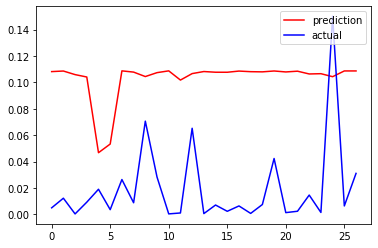

In [86]:
import matplotlib.pyplot as plt2

plt2.plot(preds,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='actual')
plt2.legend(loc='upper right')
plt2.show()

In [87]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
